<a href="https://colab.research.google.com/github/igumiao/nlp_G60/blob/xiaohong/Group60__COMP90042_Project_2025.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 2025 COMP90042 Project
*Make sure you change the file name with your group id.*

# Readme
*If there is something to be noted for the marker, please mention here.*

*If you are planning to implement a program with Object Oriented Programming style, please put those the bottom of this ipynb file*

# 1.DataSet Processing
(You can add as many code blocks and text blocks as you need. However, YOU SHOULD NOT MODIFY the section title)

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\10762\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\10762\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\10762\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Using GPU: NVIDIA GeForce RTX 3060 Laptop GPU
Loading ./data\train-claims.json...
Successfully loaded 1228 items.
Loading ./data\dev-claims.json...
Successfully loaded 154 items.
Loading ./data\test-claims-unlabelled.json...
Successfully loaded 153 items.
Loading ./data\evidence.json...
Successfully loaded 1208827 items.

=== Sample Data Structure ===
Sample claim ID: claim-1937
{
  "claim_text": "Not only is there no scientific evidence that CO2 is a pollutant, higher CO2 concentrations actually help ecosystems support more plant and animal life.",
  "claim_label": "DISPUTED",
  "evidences": [
    "evidence-442946",
    "evidence-1194317",
    "evidence-12171"
  ]
}

Sample evidence ID: evidence-0
Evidence text: John Bennet Lawes, English entrepreneur and agricultural scientist

=== Basic Analysis of Training Claims Dataset ===
Number of items: 1228

Claim_text Length Statistics (in words):
  Average length: 20.10
  Maximum length: 67
  Minimum length: 4

=== Basic Analysis of Develop

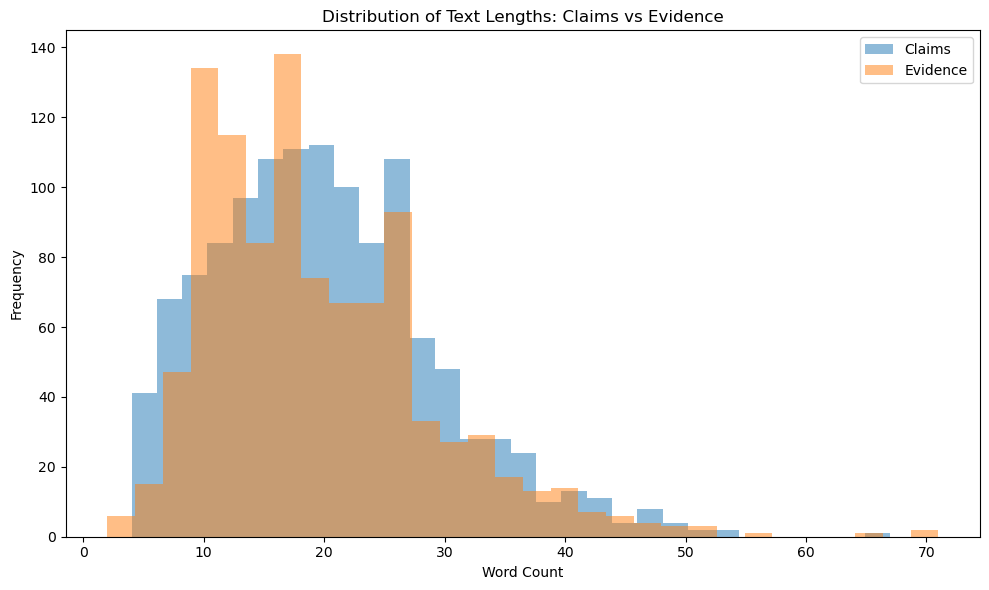


=== Preprocessing Examples ===
Original claim: Not only is there no scientific evidence that CO2 is a pollutant, higher CO2 concentrations actually help ecosystems support more plant and animal life.
Basic preprocessing: not only is there no scientific evidence that co2 is a pollutant higher co2 concentrations actually help ecosystems support more plant and animal life
With stopword removal: scientific evidence co2 pollutant higher co2 concentrations actually help ecosystems support plant animal life
With lemmatization: not only is there no scientific evidence that co2 is a pollutant higher co2 concentration actually help ecosystem support more plant and animal life
With stemming: not onli is there no scientif evid that co2 is a pollut higher co2 concentr actual help ecosystem support more plant and anim life

Original evidence: John Bennet Lawes, English entrepreneur and agricultural scientist
Basic preprocessing: john bennet lawes english entrepreneur and agricultural scientist
With

In [ ]:
# 1. DataSet Processing

# Import necessary libraries
import os
import json
import numpy as np
import matplotlib.pyplot as plt
import re
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
from collections import Counter
import time
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split

# Download NLTK resources
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('wordnet')

# --- Configuration ---
DRIVE_DATA_PATH = './data'  # Path to the data directory

# Set device to GPU if available, otherwise CPU
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("Using GPU:", torch.cuda.get_device_name(0))
else:
    device = torch.device("cpu")
    print("Using CPU")

# File paths
TRAIN_CLAIMS_PATH = os.path.join(DRIVE_DATA_PATH, 'train-claims.json')
DEV_CLAIMS_PATH = os.path.join(DRIVE_DATA_PATH, 'dev-claims.json')
TEST_CLAIMS_PATH = os.path.join(DRIVE_DATA_PATH, 'test-claims-unlabelled.json')
EVIDENCE_PATH = os.path.join(DRIVE_DATA_PATH, 'evidence.json')
DEV_PREDICTIONS_PATH = os.path.join(DRIVE_DATA_PATH, 'dev-claims-predictions.json')
TEST_PREDICTIONS_PATH = os.path.join(DRIVE_DATA_PATH, 'test-claims-predictions.json')
EVAL_SCRIPT_PATH = os.path.join('eval.py')

# --- Helper Functions ---
def load_json(filepath):
    """Loads JSON data from a file."""
    print(f"Loading {filepath}...")
    try:
        with open(filepath, 'r', encoding='utf-8') as f:
            data = json.load(f)
        print(f"Successfully loaded {len(data)} items.")
        return data
    except FileNotFoundError:
        print(f"Error: File not found at {filepath}")
        return None
    except json.JSONDecodeError as e:
        print(f"Error: Could not decode JSON from {filepath}. Error: {e}")
        return None

def preprocess_text(text, remove_stop_words=False, lemmatize=False, stem=False):
    """
    Preprocess text with multiple options:
    - Lowercase
    - Remove special characters
    - Optional: Remove stopwords
    - Optional: Lemmatization
    - Optional: Stemming
    """
    # Convert to lowercase
    text = text.lower()
    
    # Remove special characters and extra spaces
    text = re.sub(r'[^\w\s]', ' ', text)
    text = re.sub(r'\s+', ' ', text).strip()
    
    # Tokenize the text
    tokens = word_tokenize(text)
    
    # Remove stopwords if requested
    if remove_stop_words:
        stop_words = set(stopwords.words('english'))
        tokens = [word for word in tokens if word not in stop_words]
    
    # Apply lemmatization if requested
    if lemmatize:
        lemmatizer = WordNetLemmatizer()
        tokens = [lemmatizer.lemmatize(word) for word in tokens]
    
    # Apply stemming if requested
    if stem:
        stemmer = PorterStemmer()
        tokens = [stemmer.stem(word) for word in tokens]
    
    # Join the tokens back to a string
    processed_text = ' '.join(tokens)
    
    return processed_text

def basic_dataset_analysis(data_dict, name):
    """Basic analysis of a dataset (claims or evidence)."""
    print(f"\n=== Basic Analysis of {name} Dataset ===")
    print(f"Number of items: {len(data_dict)}")
    
    # For claims, check label distribution
    if name == 'Claims' and 'claim_label' in next(iter(data_dict.values())):
        labels = [item.get('claim_label') for item in data_dict.values() if 'claim_label' in item]
        label_counts = Counter(labels)
        print("\nLabel Distribution:")
        for label, count in label_counts.items():
            print(f"  {label}: {count} ({count/len(labels)*100:.2f}%)")
    
    # Check text lengths
    if 'claim_text' in next(iter(data_dict.values()), {}):
        # For claims
        text_field = 'claim_text'
        text_lengths = [len(item[text_field].split()) for item in data_dict.values()]
    else:
        # For evidence
        text_lengths = [len(text.split()) for i, text in enumerate(data_dict.values()) if i < 1000]
        text_field = 'evidence text'
    
    print(f"\n{text_field.capitalize()} Length Statistics (in words):")
    print(f"  Average length: {sum(text_lengths)/len(text_lengths):.2f}")
    print(f"  Maximum length: {max(text_lengths)}")
    print(f"  Minimum length: {min(text_lengths)}")
    
    return text_lengths

# --- 1. Load and Explore Datasets ---
train_claims = load_json(TRAIN_CLAIMS_PATH)
dev_claims = load_json(DEV_CLAIMS_PATH)
test_claims = load_json(TEST_CLAIMS_PATH)
evidence = load_json(EVIDENCE_PATH)

# Print a sample claim to understand structure
print("\n=== Sample Data Structure ===")
sample_claim_id = next(iter(train_claims))
print(f"Sample claim ID: {sample_claim_id}")
print(json.dumps(train_claims[sample_claim_id], indent=2))

# Print a sample evidence
sample_evidence_id = next(iter(evidence))
print(f"\nSample evidence ID: {sample_evidence_id}")
print(f"Evidence text: {evidence[sample_evidence_id]}")

# --- 2. Basic Dataset Analysis ---
train_lengths = basic_dataset_analysis(train_claims, "Training Claims")
dev_lengths = basic_dataset_analysis(dev_claims, "Development Claims")
test_lengths = basic_dataset_analysis(test_claims, "Test Claims")

# Sample evidence for analysis (avoid analyzing all 1.2M items)
sample_evidence = {k: evidence[k] for k in list(evidence.keys())[:1000]}
evidence_lengths = basic_dataset_analysis(sample_evidence, "Evidence (Sample)")

# --- 3. Create a simple visualization ---
plt.figure(figsize=(10, 6))
plt.hist(train_lengths, bins=30, alpha=0.5, label='Claims')
plt.hist(evidence_lengths, bins=30, alpha=0.5, label='Evidence')
plt.xlabel('Word Count')
plt.ylabel('Frequency')
plt.title('Distribution of Text Lengths: Claims vs Evidence')
plt.legend()
plt.tight_layout()
plt.savefig('text_length_distribution.png')
plt.show()

# --- 4. Preprocessing Examples ---
print("\n=== Preprocessing Examples ===")

# Sample a claim
sample_claim = train_claims[sample_claim_id]['claim_text']
print(f"Original claim: {sample_claim}")
print(f"Basic preprocessing: {preprocess_text(sample_claim)}")
print(f"With stopword removal: {preprocess_text(sample_claim, remove_stop_words=True)}")
print(f"With lemmatization: {preprocess_text(sample_claim, lemmatize=True)}")
print(f"With stemming: {preprocess_text(sample_claim, stem=True)}")

# Sample an evidence
sample_evidence_text = evidence[sample_evidence_id]
print(f"\nOriginal evidence: {sample_evidence_text}")
print(f"Basic preprocessing: {preprocess_text(sample_evidence_text)}")
print(f"With stopword removal: {preprocess_text(sample_evidence_text, remove_stop_words=True)}")

print("\nData processing complete!")

# 2. Model Implementation
(You can add as many code blocks and text blocks as you need. However, YOU SHOULD NOT MODIFY the section title)

#### TFIDF Retriever

In [5]:
# Define the TF-IDF Evidence Retriever class (simplified)
class TfidfEvidenceRetriever:
    """
    TF-IDF based evidence retriever that uses cosine similarity to find 
    relevant evidence passages for a given claim.
    """
    
    def __init__(self, 
                 max_features=10000, 
                 ngram_range=(1, 2), 
                 top_k=3,
                 lemmatize=False,
                 stem=False):
        """
        Initialize the TF-IDF evidence retriever.
        
        Args:
            max_features: Maximum number of features (vocabulary size)
            ngram_range: Range of n-grams to include (e.g., (1, 2) for unigrams and bigrams)
            top_k: Number of evidence passages to retrieve
            lemmatize: Whether to apply lemmatization in preprocessing
            stem: Whether to apply stemming in preprocessing
        """
        self.max_features = max_features
        self.ngram_range = ngram_range
        self.top_k = top_k
        
        # Preprocessing options
        self.lemmatize = lemmatize
        self.stem = stem
        
        # These will be initialized in the fit method
        self.vectorizer = None
        self.evidence_ids = None
        self.evidence_vectors = None
        
    def fit(self, evidence_data):
        """
        Fit the TF-IDF vectorizer on the evidence data and transform
        all evidence passages to TF-IDF vectors.
        
        Args:
            evidence_data: Dictionary of evidence passages {evidence_id: text}
            
        Returns:
            self: The fitted retriever
        """
        print("Fitting TF-IDF vectorizer on evidence data...")
        start_time = time.time()
        
        # Save evidence IDs for later reference
        self.evidence_ids = list(evidence_data.keys())
        
        # Preprocess evidence texts using the preprocess_text function
        # Always remove stopwords
        evidence_texts = [
            preprocess_text(
                text, 
                remove_stop_words=True, 
                lemmatize=self.lemmatize, 
                stem=self.stem
            ) 
            for text in evidence_data.values()
        ]
        
        # Create and fit the TF-IDF vectorizer
        self.vectorizer = TfidfVectorizer(
            max_features=self.max_features,
            ngram_range=self.ngram_range,
            stop_words='english'  # Always use English stopwords
        )
        
        # Transform evidence texts to TF-IDF vectors
        self.evidence_vectors = self.vectorizer.fit_transform(evidence_texts)
        
        fit_time = time.time() - start_time
        print(f"Fitted vectorizer with {self.evidence_vectors.shape[1]} features in {fit_time:.2f} seconds")
        print(f"Created vectors for {self.evidence_vectors.shape[0]} evidence passages")
        
        return self
    
    def retrieve(self, claim_text, top_k=None):
        """
        Retrieve the most relevant evidence passages for a claim.
        
        Args:
            claim_text: The text of the claim
            top_k: Number of evidence passages to retrieve (overrides the default)
            
        Returns:
            List of evidence IDs sorted by relevance
        """
        if top_k is None:
            top_k = self.top_k
            
        # Preprocess the claim using the preprocess_text function
        # Always remove stopwords
        processed_claim = preprocess_text(
            claim_text, 
            remove_stop_words=True, 
            lemmatize=self.lemmatize, 
            stem=self.stem
        )
            
        # Transform the claim to a TF-IDF vector
        claim_vector = self.vectorizer.transform([processed_claim])
        
        # Calculate cosine similarity between the claim and all evidence passages
        similarities = cosine_similarity(claim_vector, self.evidence_vectors)[0]
        
        # Get the indices of the top-k most similar evidence passages
        top_indices = np.argsort(similarities)[-top_k:][::-1]
        
        # Return the corresponding evidence IDs
        top_evidence_ids = [self.evidence_ids[idx] for idx in top_indices]
        
        return top_evidence_ids
    
    def retrieve_with_scores(self, claim_text, top_k=None, threshold=None):
        """
        Retrieve the most relevant evidence passages for a claim, with similarity scores.
        Optionally filter by a threshold.
        
        Args:
            claim_text: The text of the claim
            top_k: Number of evidence passages to retrieve (overrides the default)
            threshold: Minimum similarity score to include (default: None)
            
        Returns:
            List of tuples (evidence_id, similarity_score) sorted by relevance
        """
        if top_k is None:
            top_k = self.top_k
            
        # Preprocess the claim using the preprocess_text function
        # Always remove stopwords
        processed_claim = preprocess_text(
            claim_text, 
            remove_stop_words=True, 
            lemmatize=self.lemmatize, 
            stem=self.stem
        )
            
        # Transform the claim to a TF-IDF vector
        claim_vector = self.vectorizer.transform([processed_claim])
        
        # Calculate cosine similarity between the claim and all evidence passages
        similarities = cosine_similarity(claim_vector, self.evidence_vectors)[0]
        
        # Get the indices of the top-k most similar evidence passages
        top_indices = np.argsort(similarities)[-top_k:][::-1]
        
        # Create a list of (evidence_id, score) tuples
        results = [(self.evidence_ids[idx], similarities[idx]) for idx in top_indices]
        
        # Filter by threshold if specified
        if threshold is not None:
            results = [(eid, score) for eid, score in results if score >= threshold]
            
        return results
    
    def get_top_terms(self, text, n=10):
        """
        Get the top terms in a text based on TF-IDF weights.
        Useful for understanding what terms are important in claims/evidence.
        
        Args:
            text: The text to analyze
            n: Number of top terms to return
            
        Returns:
            List of (term, tfidf_weight) tuples
        """
        # Preprocess the text using the preprocess_text function
        # Always remove stopwords
        processed_text = preprocess_text(
            text, 
            remove_stop_words=True, 
            lemmatize=self.lemmatize, 
            stem=self.stem
        )
            
        # Transform the text to a TF-IDF vector
        text_vector = self.vectorizer.transform([processed_text])
        
        # Get the feature names (terms)
        feature_names = self.vectorizer.get_feature_names_out()
        
        # Get the TF-IDF weights for the text
        tfidf_weights = text_vector.toarray()[0]
        
        # Sort terms by TF-IDF weight and get the top n
        top_indices = np.argsort(tfidf_weights)[-n:][::-1]
        top_terms = [(feature_names[idx], tfidf_weights[idx]) for idx in top_indices]
        
        return top_terms

In [6]:
# Define evaluation function for the evidence retriever
def evaluate_retriever(retriever, labeled_claims, evidence_data):
    """
    Evaluate the evidence retriever on labeled data.
    
    Args:
        retriever: The fitted evidence retriever
        labeled_claims: Dictionary of labeled claims with ground truth evidence
        evidence_data: Dictionary of evidence passages
        
    Returns:
        Dictionary with evaluation metrics (precision, recall, f1)
    """
    print("Evaluating retriever...")
    total_precision = 0
    total_recall = 0
    total_f1 = 0
    
    # Using a simple loop without tqdm to avoid any import issues
    for claim_id, claim_info in labeled_claims.items():
        claim_text = claim_info['claim_text']
        true_evidence_ids = claim_info.get('evidences', [])
        
        # Skip claims without evidence
        if not true_evidence_ids:
            continue
        
        # Retrieve evidence using the retriever
        retrieved_evidence_ids = retriever.retrieve(claim_text)
        
        # Calculate precision, recall, and F1
        true_positives = set(retrieved_evidence_ids).intersection(set(true_evidence_ids))
        precision = len(true_positives) / len(retrieved_evidence_ids) if retrieved_evidence_ids else 0
        recall = len(true_positives) / len(true_evidence_ids) if true_evidence_ids else 0
        
        f1 = 0
        if precision + recall > 0:
            f1 = 2 * precision * recall / (precision + recall)
        
        total_precision += precision
        total_recall += recall
        total_f1 += f1
    
    n_claims = len(labeled_claims)
    avg_precision = total_precision / n_claims
    avg_recall = total_recall / n_claims
    avg_f1 = total_f1 / n_claims
    
    print(f"Avg Precision: {avg_precision:.4f}")
    print(f"Avg Recall: {avg_recall:.4f}")
    print(f"Avg F1: {avg_f1:.4f}")
    
    return {
        'precision': avg_precision,
        'recall': avg_recall,
        'f1': avg_f1
    }

#### TFIDF configuration

In [7]:
# Create the TF-IDF evidence retriever with basic configuration
retriever_basic = TfidfEvidenceRetriever(
    max_features=10000,
    ngram_range=(1, 2),
    top_k=3,
    lemmatize=True,
    stem=False
)

# Fit the retriever on the evidence data
print("Fitting basic TF-IDF retriever...")
retriever_basic.fit(evidence)

Fitting basic TF-IDF retriever...
Fitting TF-IDF vectorizer on evidence data...
Fitted vectorizer with 10000 features in 553.83 seconds
Created vectors for 1208827 evidence passages


In [8]:
# Evaluate the basic retriever on the development set
dev_results_basic = evaluate_retriever(retriever_basic, dev_claims, evidence)
print(f"Basic TF-IDF results: {dev_results_basic}")

Evaluating retriever...
Avg Precision: 0.0736
Avg Recall: 0.0817
Avg F1: 0.0712
Basic TF-IDF results: {'precision': 0.0735930735930736, 'recall': 0.08170995670995672, 'f1': 0.07122758194186767}


In [9]:
# # Examine an example claim and retrieved evidence

# # Select a sample claim from the development set
# sample_claim_id = next(iter(dev_claims))
# sample_claim = dev_claims[sample_claim_id]['claim_text']
# print(f"Sample claim: {sample_claim}")

# # Retrieve evidence for this claim
# top_evidence_ids = retriever_basic.retrieve(sample_claim)
# print(f"Top evidence IDs: {top_evidence_ids}")

# # Print the retrieved evidence texts
# print("\nRetrieved evidence texts:")
# for i, eid in enumerate(top_evidence_ids):
#     print(f"{i+1}. {evidence[eid]}")

# # Get ground truth evidence
# true_evidence_ids = dev_claims[sample_claim_id].get('evidences', [])
# print(f"\nGround truth evidence IDs: {true_evidence_ids}")

# # Print the ground truth evidence texts
# print("\nGround truth evidence texts:")
# for i, eid in enumerate(true_evidence_ids):
#     print(f"{i+1}. {evidence[eid]}")

In [10]:
# # Optional: Experiment with stemming and lemmatization

# # Create a retriever with stemming
# retriever_stemming = TfidfEvidenceRetriever(
#     max_features=10000,
#     ngram_range=(1, 2),
#     top_k=3,
#     lemmatize=False,
#     stem=True
# )

# print("Fitting retriever with stemming...")
# retriever_stemming.fit(evidence)
# dev_results_stemming = evaluate_retriever(retriever_stemming, dev_claims, evidence)
# print(f"Stemming results: {dev_results_stemming}")

# # Create a retriever with lemmatization
# retriever_lemma = TfidfEvidenceRetriever(
#     max_features=10000,
#     ngram_range=(1, 2),
#     top_k=3,
#     lemmatize=True,
#     stem=False
# )

# print("Fitting retriever with lemmatization...")
# retriever_lemma.fit(evidence)
# dev_results_lemma = evaluate_retriever(retriever_lemma, dev_claims, evidence)
# print(f"Lemmatization results: {dev_results_lemma}")

In [11]:
# # Optional: Experiment with different top-k values
# top_k_values = [3, 5, 6, 10]
# top_k_results = {}

# # Use the best preprocessing approach based on earlier experiments
# best_retriever = retriever_basic  # Replace with the best performing retriever if different

# for k in top_k_values:
#     print(f"\nEvaluating with top_k = {k}")
    
#     # We don't need to retrain the model, just change the retrieval parameter
#     total_precision = 0
#     total_recall = 0
#     total_f1 = 0
    
#     for claim_id, claim_info in tqdm(dev_claims.items()):
#         claim_text = claim_info['claim_text']
#         true_evidence_ids = claim_info.get('evidences', [])
        
#         # Skip claims without evidence
#         if not true_evidence_ids:
#             continue
        
#         # Retrieve evidence with current k value
#         retrieved_evidence_ids = best_retriever.retrieve(claim_text, top_k=k)
        
#         # Calculate metrics
#         true_positives = set(retrieved_evidence_ids).intersection(set(true_evidence_ids))
#         precision = len(true_positives) / len(retrieved_evidence_ids) if retrieved_evidence_ids else 0
#         recall = len(true_positives) / len(true_evidence_ids) if true_evidence_ids else 0
        
#         f1 = 0
#         if precision + recall > 0:
#             f1 = 2 * precision * recall / (precision + recall)
        
#         total_precision += precision
#         total_recall += recall
#         total_f1 += f1
    
#     n_claims = len(dev_claims)
#     avg_precision = total_precision / n_claims
#     avg_recall = total_recall / n_claims
#     avg_f1 = total_f1 / n_claims
    
#     print(f"top_k={k}: Precision={avg_precision:.4f}, Recall={avg_recall:.4f}, F1={avg_f1:.4f}")
    
#     top_k_results[k] = {
#         'precision': avg_precision,
#         'recall': avg_recall,
#         'f1': avg_f1
#     }

# # Visualize top-k results
# plt.figure(figsize=(10, 6))
# ks = list(top_k_results.keys())
# precision = [top_k_results[k]['precision'] for k in ks]
# recall = [top_k_results[k]['recall'] for k in ks]
# f1 = [top_k_results[k]['f1'] for k in ks]

# plt.plot(ks, precision, 'o-', label='Precision')
# plt.plot(ks, recall, 's-', label='Recall')
# plt.plot(ks, f1, '^-', label='F1')
# plt.xlabel('top-k')
# plt.ylabel('Score')
# plt.title('Retrieval Performance vs. Number of Retrieved Passages')
# plt.legend()
# plt.grid(True)
# plt.show()

#### Task 2 LSTM classification task



In [ ]:
# Define constants for the classification task
LABEL_MAP = {
    'SUPPORTS': 0,
    'REFUTES': 1,
    'NOT_ENOUGH_INFO': 2,
    'DISPUTED': 3
}

REVERSE_LABEL_MAP = {v: k for k, v in LABEL_MAP.items()}

# Parameters for the model and training
MAX_SEQUENCE_LENGTH = 300  # Maximum length of combined claim and evidence text
EMBEDDING_DIM = 50        # Dimension of word embeddings
HIDDEN_DIM = 64           # Dimension of LSTM hidden states 
BATCH_SIZE = 32            # Batch size for training 
LEARNING_RATE = 0.001      # Learning rate for optimizer 
NUM_EPOCHS = 8            # Number of training epochs
DROPOUT_RATE = 0.3         # Dropout rate 
NUM_LAYERS= 1            # Number of LSTM layers 
NOICE_RATIO = 0.3 # Ratio of noise to add to the input 

In [34]:
# Create a vocabulary from the training data
def build_vocabulary(train_claims, evidence_data, max_size=20000):
    """
    Build a vocabulary from the training data.
    
    Args:
        train_claims: Dictionary of training claims
        evidence_data: Dictionary of evidence passages
        max_size: Maximum vocabulary size
        
    Returns:
        word_to_idx: Dictionary mapping words to indices
        idx_to_word: Dictionary mapping indices to words
    """
    print("Building vocabulary...")
    word_counts = Counter()
    
    # Process claim texts
    for claim_info in train_claims.values():
        claim_text = claim_info['claim_text']
        processed_text = preprocess_text(claim_text, remove_stop_words=True)
        word_counts.update(processed_text.split())
    
    # Process evidence texts (sample to avoid processing all evidence)
    evidence_sample = list(evidence_data.values())
    if len(evidence_sample) > 10000:
        import random
        random.seed(42)
        evidence_sample = random.sample(evidence_sample, 10000)
    
    for evidence_text in evidence_sample:
        processed_text = preprocess_text(evidence_text, remove_stop_words=True, lemmatize=False, stem=False)
        word_counts.update(processed_text.split())
    
    # Create vocabulary with special tokens and most common words
    vocab = ['<PAD>', '<UNK>']  # Add special tokens
    vocab.extend([word for word, count in word_counts.most_common(max_size - len(vocab))])
    
    # Create word-to-index and index-to-word mappings
    word_to_idx = {word: idx for idx, word in enumerate(vocab)}
    idx_to_word = {idx: word for word, idx in word_to_idx.items()}
    
    print(f"Vocabulary size: {len(word_to_idx)}")
    return word_to_idx, idx_to_word

In [35]:
class ClaimDataset(Dataset):
    """Dataset for claim classification with bias exposure during training."""
    def __init__(self, claims_data, evidence_data, word_to_idx, max_length=MAX_SEQUENCE_LENGTH, 
                 use_retrieved_evidence=True, training_mode=False, noise_ratio=0.2):
        self.texts = []
        self.labels = []
        self.claim_ids = []
        self.max_length = max_length
        self.word_to_idx = word_to_idx
        self.pad_idx = word_to_idx['<PAD>']
        self.unk_idx = word_to_idx['<UNK>']
        self.training_mode = training_mode
        self.noise_ratio = noise_ratio
        
        # Process each claim
        for claim_id, claim_info in claims_data.items():
            claim_text = claim_info['claim_text']
            
            # Get evidence IDs - either from retriever or ground truth
            if use_retrieved_evidence and 'retrieved_evidences' in claim_info:
                evidence_ids = claim_info['retrieved_evidences']
            else:
                evidence_ids = claim_info.get('evidences', [])
            
            # Get evidence texts
            evidence_texts = [evidence_data.get(eid, "") for eid in evidence_ids]
            
            # If in training mode, add some incorrect evidence (bias exposure)
            if training_mode and 'claim_label' in claim_info and evidence_ids:
                evidence_texts = self._add_noise_evidence(evidence_texts, evidence_data, evidence_ids)
            
            # Combine claim and evidence
            combined_text = claim_text + " " + " ".join(evidence_texts)
            processed_text = preprocess_text(combined_text, remove_stop_words=True, lemmatize=False, stem=False)
            
            # Convert words to indices
            tokens = processed_text.split()
            indices = [self.word_to_idx.get(word, self.unk_idx) for word in tokens[:max_length]]
            
            # Pad or truncate
            if len(indices) < max_length:
                indices = indices + [self.pad_idx] * (max_length - len(indices))
            else:
                indices = indices[:max_length]
            
            # Get label if available (for training/dev)
            if 'claim_label' in claim_info:
                label = LABEL_MAP[claim_info['claim_label']]
            else:
                label = -1  # For test data
            
            self.claim_ids.append(claim_id)
            self.texts.append(indices)
            self.labels.append(label)
    
    def _add_noise_evidence(self, correct_evidence_texts, evidence_data, correct_ids):
        """Add some incorrect evidence to simulate retrieval errors."""
        import random
        
        # Calculate number of incorrect evidence to add
        num_incorrect = max(1, int(len(correct_evidence_texts) * self.noise_ratio))
        
        # Sample from all evidence IDs excluding the correct ones
        all_evidence_ids = list(evidence_data.keys())
        incorrect_ids = [eid for eid in all_evidence_ids if eid not in correct_ids]
        
        # Only add noise if we have enough evidence to sample from
        if incorrect_ids:
            sampled_incorrect = random.sample(incorrect_ids, min(num_incorrect, len(incorrect_ids)))
            incorrect_texts = [evidence_data[eid] for eid in sampled_incorrect]
            
            # Mix the correct and incorrect evidence
            mixed_evidence = correct_evidence_texts + incorrect_texts
            random.shuffle(mixed_evidence)  # Shuffle to avoid positional bias
            
            return mixed_evidence
        else:
            return correct_evidence_texts
    
    def __len__(self):
        return len(self.claim_ids)
    
    def __getitem__(self, idx):
        return {
            'claim_id': self.claim_ids[idx],
            'text': torch.tensor(self.texts[idx], dtype=torch.long),
            'label': torch.tensor(self.labels[idx], dtype=torch.long)
        }

In [36]:
# # Create a PyTorch dataset for claim classification
# class ClaimClassificationDataset(Dataset):
#     def __init__(self, claims_data, evidence_data, word_to_idx, 
#                  max_length=MAX_SEQUENCE_LENGTH, use_retrieved_evidence=True):
#         """
#         Dataset for claim classification.
        
#         Args:
#             claims_data: Dictionary of claims
#             evidence_data: Dictionary of evidence passages
#             word_to_idx: Vocabulary mapping
#             max_length: Maximum sequence length
#             use_retrieved_evidence: If True, use retrieved evidence; if False, use ground truth evidence
#         """
#         self.claims = []
#         self.texts = []
#         self.labels = []
#         self.max_length = max_length
#         self.word_to_idx = word_to_idx
#         self.pad_idx = word_to_idx['<PAD>']
#         self.unk_idx = word_to_idx['<UNK>']
        
#         print("Preparing classification dataset...")
        
#         for claim_id, claim_info in claims_data.items():
#             claim_text = claim_info['claim_text']
            
#             # Get evidence IDs and corresponding texts
#             if use_retrieved_evidence and 'retrieved_evidences' in claim_info:
#                 evidence_ids = claim_info['retrieved_evidences']
#             else:
#                 evidence_ids = claim_info.get('evidences', [])
            
#             evidence_texts = [evidence_data.get(eid, "") for eid in evidence_ids]
            
#             # Skip if no evidence (for training data)
#             if not evidence_texts and 'claim_label' in claim_info:
#                 continue
            
#             # Combine claim and evidence texts
#             combined_text = claim_text + " " + " ".join(evidence_texts)
            
#             # Preprocess and tokenize
#             processed_text = preprocess_text(combined_text, remove_stop_words=True)
#             tokens = processed_text.split()
            
#             # Convert tokens to indices
#             indices = [self.word_to_idx.get(token, self.unk_idx) for token in tokens[:self.max_length]]
            
#             # Pad or truncate to max_length
#             if len(indices) < self.max_length:
#                 indices = indices + [self.pad_idx] * (self.max_length - len(indices))
#             else:
#                 indices = indices[:self.max_length]
            
#             # Get label (if available)
#             if 'claim_label' in claim_info:
#                 label = LABEL_MAP[claim_info['claim_label']]
#             else:
#                 label = -1  # For test data
            
#             self.claims.append(claim_id)
#             self.texts.append(indices)
#             self.labels.append(label)
    
#     def __len__(self):
#         return len(self.claims)
    
#     def __getitem__(self, idx):
#         return {
#             'claim_id': self.claims[idx],
#             'text': torch.tensor(self.texts[idx], dtype=torch.long),
#             'label': torch.tensor(self.labels[idx], dtype=torch.long)
#         }

In [37]:
# Define the LSTM model for claim classification with enhanced regularization
class LSTMClassifier(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, dropout_rate=0.4,
                bidirectional=True, num_layers=1):
        """
        LSTM-based classifier for claim verification with enhanced regularization.
        
        Args:
            vocab_size: Size of the vocabulary
            embedding_dim: Dimension of word embeddings
            hidden_dim: Dimension of LSTM hidden states
            output_dim: Number of output classes
            dropout_rate: Dropout rate for regularization
            bidirectional: Whether to use bidirectional LSTM
            num_layers: Number of LSTM layers
        """
        super(LSTMClassifier, self).__init__()
        
        # Add embedding layer with dropout
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        self.emb_dropout = nn.Dropout(dropout_rate/2)  # Lighter dropout for embeddings
        
        # LSTM layer with existing parameters
        self.lstm = nn.LSTM(embedding_dim,
                          hidden_dim,
                          num_layers=num_layers,
                          bidirectional=bidirectional,
                          dropout=dropout_rate if num_layers > 1 else 0,
                          batch_first=True)
        
        # If bidirectional, hidden_dim is doubled
        self.fc_dim = hidden_dim * 2 if bidirectional else hidden_dim
        
        # # Add batch normalization between LSTM and FC layer (helps stabilize training)
        # self.batch_norm = nn.BatchNorm1d(self.fc_dim)
        
        # Existing FC layers with increased dropout
        self.fc1 = nn.Linear(self.fc_dim, hidden_dim)
        self.dropout1 = nn.Dropout(dropout_rate)  # After first FC layer
        self.fc2 = nn.Linear(hidden_dim, output_dim)
        
    def forward(self, text):
        # text: [batch_size, seq_len]
        
        # Apply embedding with dropout
        embedded = self.embedding(text)  # [batch_size, seq_len, embedding_dim]
        embedded = self.emb_dropout(embedded)  # Apply dropout to embeddings
        
        # Push through LSTM
        output, (hidden, cell) = self.lstm(embedded)  # output: [batch_size, seq_len, hidden_dim*2]
        
        # Use the final hidden state of each direction
        if self.lstm.bidirectional:
            hidden = torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim=1)  # [batch_size, hidden_dim*2]
        else:
            hidden = hidden[-1,:,:]  # [batch_size, hidden_dim]
        
        # # Apply batch normalization
        # hidden = self.batch_norm(hidden)
        
        # Push through fully connected layers with enhanced regularization
        dense1 = torch.relu(self.fc1(hidden))
        dense1 = self.dropout1(dense1)  # Apply dropout
        output = self.fc2(dense1)  # [batch_size, output_dim]
        
        return output

In [38]:
# Function to train the model
def train_model(model, train_loader, valid_loader, optimizer, criterion, num_epochs=NUM_EPOCHS):
    """
    Train the classification model.
    
    Args:
        model: The LSTM model
        train_loader: DataLoader for training data
        valid_loader: DataLoader for validation data
        optimizer: Optimizer for parameter updates
        criterion: Loss function
        num_epochs: Number of training epochs
        
    Returns:
        List of training losses, training accuracies, validation losses, validation accuracies
    """
    # Make sure model is on the correct device
    model = model.to(device)
    
    # Track metrics
    train_losses = []
    train_accs = []
    valid_losses = []
    valid_accs = []
    
    for epoch in range(num_epochs):
        # Training phase
        model.train()
        train_loss = 0
        correct = 0
        total = 0
        
        for batch in train_loader:
            # Move batch to device
            text = batch['text'].to(device)
            labels = batch['label'].to(device)
            
            # Zero the gradients
            optimizer.zero_grad()
            
            # Forward pass
            outputs = model(text)
            
            # Calculate loss
            loss = criterion(outputs, labels)
            
            # Backward pass and optimize
            loss.backward()
            optimizer.step()
            
            # Update metrics
            train_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        
        # Calculate epoch metrics
        epoch_loss = train_loss / len(train_loader)
        epoch_acc = 100 * correct / total
        train_losses.append(epoch_loss)
        train_accs.append(epoch_acc)
        
        # Validation phase
        model.eval()
        valid_loss = 0
        correct = 0
        total = 0
        
        with torch.no_grad():
            for batch in valid_loader:
                # Move batch to device
                text = batch['text'].to(device)
                labels = batch['label'].to(device)
                
                # Forward pass
                outputs = model(text)
                
                # Calculate loss
                loss = criterion(outputs, labels)
                
                # Update metrics
                valid_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        
        # Calculate epoch metrics
        epoch_loss = valid_loss / len(valid_loader)
        epoch_acc = 100 * correct / total
        valid_losses.append(epoch_loss)
        valid_accs.append(epoch_acc)
        
        print(f"Epoch {epoch+1}/{num_epochs}, "
              f"Train Loss: {train_losses[-1]:.4f}, Train Acc: {train_accs[-1]:.2f}%, "
              f"Valid Loss: {valid_losses[-1]:.4f}, Valid Acc: {valid_accs[-1]:.2f}%")
    
    return train_losses, train_accs, valid_losses, valid_accs

In [39]:
# Function to evaluate model on development set
def evaluate_model(model, data_loader):
    """
    Evaluate the model on a dataset.
    
    Args:
        model: The trained model
        data_loader: DataLoader for evaluation data
        
    Returns:
        Dictionary with evaluation metrics
    """
    model.eval()
    correct = 0
    total = 0
    predictions = {}
    
    with torch.no_grad():
        for batch in data_loader:
            # Move batch to device
            text = batch['text'].to(device)
            labels = batch['label'].to(device)
            claim_ids = batch['claim_id']
            
            # Forward pass
            outputs = model(text)
            
            # Get predictions
            _, predicted = torch.max(outputs.data, 1)
            
            # Update metrics
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
            # Save predictions
            for i, claim_id in enumerate(claim_ids):
                pred_idx = predicted[i].item()
                predictions[claim_id] = REVERSE_LABEL_MAP[pred_idx]
    
    accuracy = 100 * correct / total if total > 0 else 0
    print(f"Evaluation Accuracy: {accuracy:.2f}%")
    
    return {
        'accuracy': accuracy,
        'predictions': predictions
    }

In [40]:
# Function to make predictions on test set
def predict(model, data_loader):
    """
    Make predictions on a dataset.
    
    Args:
        model: The trained model
        data_loader: DataLoader for prediction data
        
    Returns:
        Dictionary mapping claim IDs to predicted labels
    """
    model.eval()
    predictions = {}
    
    with torch.no_grad():
        for batch in data_loader:
            # Move batch to device
            text = batch['text'].to(device)
            claim_ids = batch['claim_id']
            
            # Forward pass
            outputs = model(text)
            
            # Get predictions
            _, predicted = torch.max(outputs.data, 1)
            
            # Save predictions
            for i, claim_id in enumerate(claim_ids):
                pred_idx = predicted[i].item()
                predictions[claim_id] = REVERSE_LABEL_MAP[pred_idx]
    
    return predictions

# 3.Testing and Evaluation
(You can add as many code blocks and text blocks as you need. However, YOU SHOULD NOT MODIFY the section title)

In [41]:
# Run the training and evaluation process
def run_claim_classification(
    train_claims, dev_claims, test_claims, evidence, retriever=None
):
    """
    Run the entire claim classification pipeline: build vocabulary, prepare datasets,
    train and evaluate model, make predictions.

    Args:
        train_claims: Dictionary of training claims
        dev_claims: Dictionary of development claims
        test_claims: Dictionary of test claims
        evidence: Dictionary of evidence passages
        retriever: Evidence retriever to get evidence for claims (if None, use ground truth)

    Returns:
        dev_predictions: Predictions on development set
        test_predictions: Predictions on test set
    """
    # Step 1: Retrieve evidence for claims (if retriever is provided)
    if retriever:
        print("Retrieving evidence for claims...")
        for split_name, claims in [
            ("training", train_claims),
            ("development", dev_claims),
            ("test", test_claims),
        ]:
            print(f"Processing {split_name} claims...")
            for claim_id, claim_info in claims.items():
                claim_text = claim_info["claim_text"]
                retrieved_evidence = retriever.retrieve(claim_text)
                claims[claim_id]["retrieved_evidences"] = retrieved_evidence

    # Step 2: Build vocabulary
    word_to_idx, idx_to_word = build_vocabulary(train_claims, evidence)

    # Step 3: Prepare datasets
    use_retrieved = retriever is not None

    # Create datasets with bias exposure for training
    train_dataset = ClaimDataset(
        train_claims,
        evidence,
        word_to_idx,
        use_retrieved_evidence=use_retrieved,
        training_mode=True,  # Enable bias exposure
        noise_ratio=NOICE_RATIO,
    )  # Add 30% noise

    # Split training data for validation
    train_size = int(0.9 * len(train_dataset))
    val_size = len(train_dataset) - train_size
    train_subset, val_subset = torch.utils.data.random_split(
        train_dataset,
        [train_size, val_size],
        generator=torch.Generator().manual_seed(42),
    )

    # For development and test, don't add noise
    dev_dataset = ClaimDataset(
        dev_claims,
        evidence,
        word_to_idx,
        use_retrieved_evidence=use_retrieved,
        training_mode=False,
    )  # No noise for evaluation
    test_dataset = ClaimDataset(
        test_claims,
        evidence,
        word_to_idx,
        use_retrieved_evidence=use_retrieved,
        training_mode=False,
    )  # No noise for testing

    # Create data loaders
    train_loader = DataLoader(train_subset, batch_size=BATCH_SIZE, shuffle=True)
    val_loader = DataLoader(val_subset, batch_size=BATCH_SIZE)
    dev_loader = DataLoader(dev_dataset, batch_size=BATCH_SIZE)
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE)

    # Step 5: Initialize model, loss function, and optimizer
    model = LSTMClassifier(
        vocab_size=len(word_to_idx),
        embedding_dim=EMBEDDING_DIM,
        hidden_dim=HIDDEN_DIM,
        output_dim=len(LABEL_MAP),
        dropout_rate=DROPOUT_RATE,
        bidirectional=True,
        num_layers=NUM_LAYERS,
    )

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=1e-4)

    # Step 6: Train model
    print("\nTraining LSTM classifier...")
    # Use val_loader (internal validation) instead of dev_loader during training
    history = train_model(
        model, train_loader, val_loader, optimizer, criterion, num_epochs=NUM_EPOCHS
    )

    # Step 7: After training, evaluate on the development set
    print("\nEvaluating on development set...")
    dev_results = evaluate_model(model, dev_loader)

    # Step 8: Predict on test set
    print("\nPredicting on test set...")
    test_predictions = predict(model, test_loader)

    # Step 9: Prepare prediction dictionaries with both labels and evidence
    dev_predictions = {}
    for claim_id, label in dev_results["predictions"].items():
        evidence_ids = (
            dev_claims[claim_id].get("retrieved_evidences", [])
            if use_retrieved
            else dev_claims[claim_id].get("evidences", [])
        )
        dev_predictions[claim_id] = {
            "claim_text": dev_claims[claim_id]["claim_text"],
            "claim_label": label,
            "evidences": evidence_ids,
        }

    test_predictions_dict = {}
    for claim_id, label in test_predictions.items():
        evidence_ids = (
            test_claims[claim_id].get("retrieved_evidences", [])
            if use_retrieved
            else []
        )
        test_predictions_dict[claim_id] = {
            "claim_text": test_claims[claim_id]["claim_text"],
            "claim_label": label,
            "evidences": evidence_ids,
        }

    return dev_predictions, test_predictions_dict, model

In [42]:
# Get predictions using the TF-IDF retriever from Part 2
# Make sure to run this after you have trained the retriever in Part 2

# First check if we have a retriever from previous cells
if 'retriever_basic' in globals():
    retriever = retriever_basic
    print("Using the basic TF-IDF retriever from Part 2")
else:
    print("Retriever not found, creating a new TF-IDF retriever...")
    # Create and train a basic retriever
    retriever = TfidfEvidenceRetriever(
        max_features=10000,
        ngram_range=(1, 2),
        top_k=6
    )
    retriever.fit(evidence)

# Run the claim classification pipeline
dev_predictions, test_predictions, claim_classifier = run_claim_classification(
    train_claims=train_claims,  # Only use training data for training
    dev_claims=dev_claims,      # Use dev only for evaluation
    test_claims=test_claims,
    evidence=evidence,
    retriever=retriever
)

Using the basic TF-IDF retriever from Part 2
Retrieving evidence for claims...
Processing training claims...
Processing development claims...
Processing test claims...
Building vocabulary...
Vocabulary size: 20000

Training LSTM classifier...
Epoch 1/8, Train Loss: 1.3147, Train Acc: 39.91%, Valid Loss: 1.2430, Valid Acc: 46.34%
Epoch 2/8, Train Loss: 1.2500, Train Acc: 41.45%, Valid Loss: 1.2408, Valid Acc: 46.34%
Epoch 3/8, Train Loss: 1.2410, Train Acc: 42.90%, Valid Loss: 1.2445, Valid Acc: 46.34%
Epoch 4/8, Train Loss: 1.2148, Train Acc: 43.08%, Valid Loss: 1.2610, Valid Acc: 43.90%
Epoch 5/8, Train Loss: 1.1721, Train Acc: 46.52%, Valid Loss: 1.3090, Valid Acc: 38.21%
Epoch 6/8, Train Loss: 1.1225, Train Acc: 49.05%, Valid Loss: 1.3217, Valid Acc: 34.15%
Epoch 7/8, Train Loss: 1.0581, Train Acc: 53.48%, Valid Loss: 1.3722, Valid Acc: 34.96%
Epoch 8/8, Train Loss: 0.9817, Train Acc: 57.65%, Valid Loss: 1.4297, Valid Acc: 29.27%

Evaluating on development set...
Evaluation Accuracy

In [43]:
# Save predictions to files
def save_predictions(dev_predictions, test_predictions):
    """
    Save predictions to JSON files.
    """
    # Save development predictions
    with open(DEV_PREDICTIONS_PATH, 'w') as f:
        json.dump(dev_predictions, f, indent=2)
    print(f"Saved development predictions to {DEV_PREDICTIONS_PATH}")
    
    # Save test predictions
    with open(TEST_PREDICTIONS_PATH, 'w') as f:
        json.dump(test_predictions, f, indent=2)
    print(f"Saved test predictions to {TEST_PREDICTIONS_PATH}")

# Save predictions
save_predictions(dev_predictions, test_predictions)

Saved development predictions to ./data\dev-claims-predictions.json
Saved test predictions to ./data\test-claims-predictions.json


## Object Oriented Programming codes here

*You can use multiple code snippets. Just add more if needed*